<img src='https://i.imgur.com/lCuxDSV.png'>

# 1. Introduction 📜

This notebook is just me being frustrated on **deep learning** and trying to understand in "baby steps" what is going on here. For somebody that starts in this area with no background whatsoever it can be very confusing, especially because I seem to be unable to find code with many explanations and comments.

So, if you are frustrated just like I was when I started this stuff I hope the following guidelines will help you. I am by no means a teacher, but in this notebook I will:
1. Share articles/videos I watched that TRULY helped
2. Explain code along the way to the best of my ability

<div class="alert alert-block alert-warning"> 
<strong>Note</strong>: Deep learning coding is VERY different in structure than the usual <em>sklearn</em> for machine learning. In addition, it usually works with <em>images</em> and <em>text</em>, while <em>ML</em> usually works with <em>tabular</em> data. So please, be patient with yourself and if you don't understand something right away, continue reading/ coding and it will all make sense in the end.
</div>

<img src='https://i.imgur.com/yXdmIr5.png' width=500>

# 2. Before we start 📝

> This is my third notebook in the "series": **How I taught myself Deep Learning**.
1. **[How I taught myself Deep Learning: Vanilla NNs](https://www.kaggle.com/andradaolteanu/how-i-taught-myself-deep-learning-1-pytorch-fnn)**
        * PyTorch and Tensors
        * Neural Network Basics, Perceptrons and a Plain Vanilla Neural Net model
        * MNIST Classification using FNN
        * Activation Functions
        * Forward Pass
        * Backpropagation (Loss and Optimizer Functions)
        * Batching, Iterations and Epochs
        * Computing Classification Accuracy
        * Overfitting: Data Augmentation, Weight Decay, Learning Rate, Dropout() and Layer Optimization   
2. **[Convolutional Neural Nets (CNNs) Explained](https://www.kaggle.com/andradaolteanu/convolutional-neural-nets-cnns-explained)**
        * Why ConvNets
        * Convolutions Explained
        * Computing Activation Maps
        * Kernels, Padding, Stride
        * AlexNet
        * MNIST Classification using Convolutions

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random

# To display youtube videos
from IPython.display import YouTubeVideo


def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cpu


# 3. RNN with 1 Layer 📘
Recurrent Neural Networks are very different from [FNNs](https://www.kaggle.com/andradaolteanu/how-i-taught-myself-deep-learning-vanilla-nns) or [CNNs](https://www.kaggle.com/andradaolteanu/how-i-taught-myself-deep-learning-convnet-cnns). 

RNNs model **sequential data**, meaning they have **sequential memory**. An RNN takes in different kind of inputs (text, words, letters, parts of an image, sounds, etc.) and returns different kinds of outputs (the next word/letter in the sequence, paired with an FNN it can return a classification etc.).

<img src="https://i.imgur.com/RW41Wqj.png" width="600">

**How RNN works**:
1. It uses previous information to affect later ones
2. There are 3 layers: *Input*, *Output* and *Hidden* (where the information is stored)
3. The loop: passes the input forward sequentialy, while *retaining information* about it
4. This info is stored in the *hidden state*
5. There are only 3 matrixes (U, V, W) that contain weights as parameters. These *DON'T change* with the input, they stay the same through the entire sequence.

## 3.1 Youtube Videos to Save you Time 🎥
I *highly recommend* watching the following to better understand RNNs.

<div class="alert alert-block alert-info">
<img src='https://i.imgur.com/H6AnLaj.png' width='70' align='left'></img>
<p><a href='https://www.youtube.com/watch?v=LHXXI4-IEns'>Ilustrated Guide to Recurrent Neural Networks: Understanding the Intuition</a></p>
<p>From Michael Phi</p>
</div>

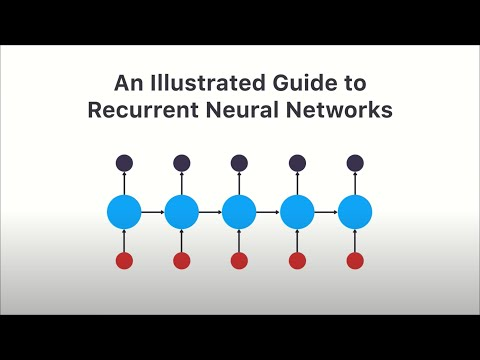

In [2]:
YouTubeVideo("LHXXI4-IEns", width=500, height=200)

## 3.2 RNN with 1 Layer and 1 Neuron (🎇)
You can always increase the number of neurons in an RNN. For the moment we'll stick with 1. We'll have 2 timesteps, 0 and 1. The Architecture of our `class` will look like the figure below:

<img src='https://i.imgur.com/Nxa3XzS.png' width='400'>

* `torch.mm()` - matrix multiplication

In [3]:
# ==== STATICS ====
n_inputs = 4
n_neurons = 1
# =================

# RNN inputs
input0 = torch.tensor([[0, 1, 2, 0], [3, 4, 5, 0], [6, 7, 8, 0], [9, 0, 1, 0]], dtype = torch.float)
print('input time_0 shape:', input0.shape)

input1 = torch.tensor([[9, 8, 7, 0], [3, 4, 5, 0], [6, 7, 8, 0], [9, 0, 1, 0]], dtype = torch.float)
print('input time_1 shape:', input1.shape)

input time_0 shape: torch.Size([4, 4])
input time_1 shape: torch.Size([4, 4])


In [4]:
# The Neural Network
class RNNVanilla(nn.Module):
    # __init__: the function where we create the architecture
    def __init__(self, n_inputs, n_neurons):
        super(RNNVanilla, self).__init__()
        
        # Weights are random at first
        # U contains connection weights for the inputs of the current time step
        self.U = torch.randn(n_inputs, n_neurons) # for 1 neuron: size = 4 rows and 1 column
        
        # W contains connection weights for the outputs of the previous time step
        self.W = torch.randn(n_neurons, n_neurons) # for 1 neuron: size = 1 row and 1 column
        
        # The bias
        self.b = torch.zeros(1, n_neurons) # for 1 neuron: size = 1 row and 1 column
    
    # forward: function where we apply the architecture to the input
    def forward(self, input0, input1):
        # Computes two outputs, one for each time step (two overall).
        self.output0 = torch.tanh(torch.mm(input0, self.U) + self.b)
        
        self.output1 = torch.tanh(torch.mm(self.output0, self.W) + torch.mm(input1, self.U) + self.b)
        
        return self.output0, self.output1
    

In [5]:
# Creating the model
rnn_1_neuron = RNNVanilla(n_inputs, n_neurons)

# Checking the output
output0, output1 = rnn_1_neuron(input0, input1)
print('output0:', output0, '\n')
print('output1:', output1)

output0: tensor([[-0.9247],
        [-0.9973],
        [-0.9999],
        [-0.5345]]) 

output1: tensor([[-0.9937],
        [-0.9910],
        [-0.9997],
        [-0.2628]])


In [6]:
# Parameters
print('U:', rnn_1_neuron.U)
print('W:', rnn_1_neuron.W)
print('bias:', rnn_1_neuron.b)

U: tensor([[ 0.0461],
        [ 0.4024],
        [-1.0115],
        [ 0.2167]])
W: tensor([[-0.6123]])
bias: tensor([[0.]])


## 3.3 RNN with 1 Layer and Multiple Neurons (🎇🎇🎇)

**Difference vs RNN 1 neuron 1 layer:**
* size of output changes (because size of `n_neurons` changes)
* size of the bias changes (it's the size of `n_neurons`) and `W` matrix
    
<img src='https://i.imgur.com/QV9nCUY.png' width='400'>

In [7]:
# ==== STATICS ====
n_inputs = 3
n_neurons = 5
# =================

# RNN inputs
input0 = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]], dtype = torch.float)
print('input time_0 shape:', input0.shape)

input1 = torch.tensor([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]], dtype = torch.float)
print('input time_1 shape:', input1.shape)

input time_0 shape: torch.Size([4, 3])
input time_1 shape: torch.Size([4, 3])


In [8]:
# Creating the model
rnn_n_neurons = RNNVanilla(n_inputs, n_neurons)

# Checking the output
output0, output1 = rnn_n_neurons(input0, input1)
print('output0:', output0, '\n')
print('output1:', output1)

output0: tensor([[ 0.9538, -0.6534,  0.7879, -0.8832, -0.9953],
        [ 1.0000, -0.9287,  0.9998, -1.0000, -0.8423],
        [ 1.0000, -0.9870,  1.0000, -1.0000,  0.5144],
        [ 1.0000,  0.9486,  1.0000, -0.9840,  1.0000]]) 

output1: tensor([[ 1.0000, -0.9795,  1.0000, -1.0000,  1.0000],
        [-0.4268, -0.6269,  0.9398,  0.9575, -0.9623],
        [ 1.0000, -0.9559,  1.0000, -1.0000,  0.9999],
        [ 0.9991,  0.5718,  0.9485, -0.9160,  0.9999]])


In [9]:
# Parameters
print('U:', rnn_n_neurons.U)
print('W:', rnn_n_neurons.W)
print('bias:', rnn_n_neurons.b)

U: tensor([[ 0.5036,  0.2310,  0.6931, -0.2669,  2.1785],
        [ 0.1021, -0.2590, -0.1549, -1.3706, -0.1319],
        [ 0.8848, -0.2611,  0.6104, -0.0098, -1.4473]])
W: tensor([[ 0.7667,  0.0190,  0.0220,  1.1532, -0.3393],
        [ 0.1559,  0.8966, -0.2968, -0.6857,  0.9247],
        [ 0.1825, -0.0737,  0.3147, -1.0369,  0.2100],
        [ 0.6144, -0.0552, -0.3297, -1.7970,  0.8728],
        [ 0.7670, -0.1138, -0.9428,  0.7540,  0.1365]])
bias: tensor([[0., 0., 0., 0., 0.]])


## 3.4 Vanilla RNN for MNIST Classification 🔢

From now on we'll use the build in `nn.RNN()` from `PyTorch`. As you see, the previous examples can't support large inputs and outputs, as we would have to input the information at every timestep and output the results.

Note: When using RNN in image classification, it is hard to find the logic of "why" exactly are we doing this. It is not like CNNs, when we know we put many "filters" on the image to extract the essence. I observed that when using RNNs is just another mathematical method in which the computer learns numbers and can therefore identify patterns.

This is why RNNs might be weird in the approach for image classification, but nevertheless very effective.

<div class="alert alert-block alert-info">
RNN is a very powerful neural net. As you'll see, it's performance is far grater than a normal FNN or CNN
</div>

> Side Note: Images used as input NEED to have 1 channel (so need to be B&W)

### 3.4.1 Import the Data 📥

> Note: to further augmentations on the data, check [albumentations for PyTorch](https://albumentations.readthedocs.io/en/latest/api/augmentations.html)

In [10]:
# Customized transform (transforms to tensor, here you can normalize, perform Data Augmentation etc.)
my_transform = transforms.Compose([transforms.ToTensor()])

# Download data
mnist_train = torchvision.datasets.MNIST('data', train = True, download=True, transform=my_transform)
mnist_test = torchvision.datasets.MNIST('data', train = False, download=True, transform=my_transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)>



100%|██████████| 9912422/9912422 [01:19<00:00, 124410.68it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)>



100%|██████████| 28881/28881 [00:00<00:00, 193895.60it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1469239.26it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)>



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



### 3.4.2 RNN Architecture for MNIST Classification 🪓
> Note: Don't bother with the prints, they are there for later only to understand what's happening inside the network.

<div class="alert alert-block alert-info">
<p>Pro Tip: Use <c>print()</c> a lot if you don't understand what is happening (helps you visualize)</p>
</div>

In [11]:
# The Neural Network
class VanillaRNN_MNIST(nn.Module):
    def __init__(self, batch_size, input_size, hidden_size, output_size):
        super(VanillaRNN_MNIST, self).__init__()
        self.batch_size, self.input_size, self.hidden_size, self.output_size = batch_size, input_size, hidden_size, output_size
        
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_size)
        # Fully Connected Layer
        self.layer = nn.Linear(hidden_size, self.output_size)
    
    def forward(self, images, prints=False):
        if prints: print('Original Images Shape:', images.shape)
        
        images = images.permute(1, 0, 2)
        if prints: print('Permuted Imaged Shape:', images.shape)
        
        # Initialize hidden state with zeros
        hidden_state = torch.zeros(1, self.batch_size, self.hidden_size)
        if prints: print('Initial hidden state Shape:', hidden_state.shape)
        
        # Creating RNN
        hidden_outputs, hidden_state = self.rnn(images, hidden_state)
        
        # Log probabilities
        out = self.layer(hidden_state)
        
        if prints:
            print('----hidden_outputs shape:', hidden_outputs.shape, '\n' +
                  '----final hidden state:', hidden_state.shape, '\n' +
                  '----out shape:', out.shape)
        
        # Reshaped out
        out = out.view(-1, self.output_size)
        if prints: print('Out Final Shape:', out.shape)
        
        return out

### Understanding the Model:

> Here is what's happening to the batch below:
<img src='https://i.imgur.com/U5bzlIS.png' width=500>

- 1 Layer RNN (If there were additional layers, this dimension would increase (e.g., 2 for a 2-layer RNN), with each layer stacking on top of the previous one to capture more complex representations.)
- 28: The number of **time steps** in the sequence. This means that the input is divided into 28 parts (one for each time step).
- 64: The **batch size**, indicating there are 64 separate sequences (samples) processed in parallel.
- 28: The **input size** (or number of features),(number of inputs) at each time step. Each time step in each sequence has 28 features.

In [ ]:

# ==== STATICS ====
batch_size = 64        # how many images to be trained in one iteration
input_size = 28        # image 28 by 28 (number of inputs or number of features)
hidden_size = 150      # can be changed to any number: neurons
output_size = 10       # 10 different digits
# =================

In [13]:
# Create a train_loader to select a batch from it
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64)

# Select one full batch from the data
images_example, labels_example = next(iter(train_loader))
print('original images shape:', images_example.shape)

# Reshape
images_example = images_example.view(-1, 28, 28)
print('changed images shape:', images_example.shape)
print('labels shape:', labels_example.shape, '\n')

# Creating the model
model_example = VanillaRNN_MNIST(batch_size, input_size, hidden_size, output_size)


out = model_example(images_example, prints=True)

original images shape: torch.Size([64, 1, 28, 28])
changed images shape: torch.Size([64, 28, 28])
labels shape: torch.Size([64]) 

Original Images Shape: torch.Size([64, 28, 28])
Permuted Imaged Shape: torch.Size([28, 64, 28])
Initial hidden state Shape: torch.Size([1, 64, 150])
----hidden_outputs shape: torch.Size([28, 64, 150]) 
----final hidden state: torch.Size([1, 64, 150]) 
----out shape: torch.Size([1, 64, 10])
Out Final Shape: torch.Size([64, 10])


> If we unfold the RNN:
<img src='https://i.imgur.com/lmv7fNA.png' width=500>

In [14]:
# Understand Model Parameters
print('Len parameters:', len(list(model_example.parameters())), '\n' +
      'Parameters 0 - U:', list(model_example.parameters())[0].shape, '\n' +
      'Parameters 1 - W:', list(model_example.parameters())[1].shape, '\n' +
      'Parameters 2 - Bias:', list(model_example.parameters())[2].shape, '\n' +
      'Parameters 3 - Bias:', list(model_example.parameters())[3].shape, '\n' +
      'Parameters 4 - FNN weights:', list(model_example.parameters())[4].shape, '\n' +
      'Parameters 5 - Predictions:', list(model_example.parameters())[5].shape)

Len parameters: 6 
Parameters 0 - U: torch.Size([150, 28]) 
Parameters 1 - W: torch.Size([150, 150]) 
Parameters 2 - Bias: torch.Size([150]) 
Parameters 3 - Bias: torch.Size([150]) 
Parameters 4 - FNN weights: torch.Size([10, 150]) 
Parameters 5 - Predictions: torch.Size([10])


### 3.4.3 Training... 🚀

> We'll use `get_accuracy()` and `train_network()` functions from my [previous notebook](https://www.kaggle.com/andradaolteanu/how-i-taught-myself-deep-learning-vanilla-nns), but with some changes (suited to the RNN's needs).

In [15]:
def get_accuracy(out, actual_labels, batchSize):
    '''Saves the Accuracy of the batch.
    Takes in the log probabilities, actual label and the batchSize (to average the score).'''
    predictions = out.max(dim=1)[1]
    correct = (predictions == actual_labels).sum().item()
    accuracy = correct/batch_size
    
    return accuracy

In [16]:
def train_network(model, train_data, test_data, batchSize=64, num_epochs=1, learning_rate=0.001):
    
    '''Trains the model and computes the average accuracy for train and test data.'''
    
    print('Get data ready...')
    # Create dataloader for training dataset - so we can train on multiple batches
    # Shuffle after every epoch
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batchSize, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batchSize, shuffle=True, drop_last=True)
    
    # Create criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    
    print('Training started...')
    # Train the data multiple times
    for epoch in range(num_epochs):
        
        # Save Train and Test Loss
        train_loss = 0
        train_acc = 0
        
        # Set model in training mode:
        model.train()
        
        for k, (images, labels) in enumerate(train_loader):
            
            # Get rid of the channel
            images = images.view(-1, 28, 28)
            
            # Create log probabilities
            out = model(images)
            # Clears the gradients from previous iteration
            optimizer.zero_grad()
            # Computes loss: how far is the prediction from the actual?
            loss = criterion(out, labels)
            # Computes gradients for neurons
            loss.backward()
            # Updates the weights
            optimizer.step()
            
            # Save Loss & Accuracy after each iteration
            train_loss += loss.item()
            train_acc += get_accuracy(out, labels, batchSize)
            
        
        # Print Average Train Loss & Accuracy after each epoch
        print('TRAIN | Epoch: {}/{} | Loss: {:.2f} | Accuracy: {:.2f}'.format(epoch+1, num_epochs, train_loss/k, train_acc/k))
            
            
    print('Testing Started...')
    # Save Test Accuracy
    test_acc = 0
    # Evaluation mode
    model.eval()
    
    for k, (images, labels) in enumerate(test_loader):
        # Get rid of the channel
        images = images.view(-1, 28, 28)
        
        # Create logit predictions
        out = model(images)
        # Add Accuracy of this batch
        test_acc += get_accuracy(out, labels, batchSize)
        
    # Print Final Test Accuracy
    print('TEST | Average Accuracy per {} Loaders: {:.5f}'.format(k, test_acc/k) )

In [17]:
# ==== STATICS ====
batch_size=64
input_size=28
hidden_size=150
output_size=10

# Instantiate the model
vanilla_rnn = VanillaRNN_MNIST(batch_size, input_size, hidden_size, output_size)

# ==== TRAIN ====
train_network(vanilla_rnn, mnist_train, mnist_test, num_epochs=1)

Get data ready...
Training started...
TRAIN | Epoch: 1/1 | Loss: 0.86 | Accuracy: 0.71
Testing Started...
TEST | Average Accuracy per 155 Loaders: 0.87056


<div class="alert alert-block alert-info">
<strong>Side Note</strong>: It's AMAZING how important hyperparameters are. Try changing the <code>learning_rate</code> to 0.01 and see what happens. Also try changing the <code>batch_size</code> to 20 instead of 64. Try adding <code>weight_decay</code> to the <code>optimizer</code> functions. The accuracy of the model now is impressive, but by altering some of these hyperparameters can change this "sweet spot" we found instantly.
</div>



# 4. Multilayer RNNs 📚

## 4.1 Why multilayers?
**Why use multiple layers rather than 1?**
> to create higher-level abstractions and capture more non-linearities between the data

**Multilayers in RNN**:
* we want to create such abstractions, and at the same time enforce their correlation with the previous inputs
* for 2 layers there are 2 hidden states as output, for 3 layers there are 3 hidden states and so on
<img src='https://i.imgur.com/NIHrqIO.png' width=500>

**Activation functions: ReLU vs Tanh**
> use them to try to erase the vanishing gradients problem (we'll come back to these in the next chapter LSTM)
<img src='https://i.imgur.com/OzyalSo.png' width=500>

## 4.2 Multilayer RNN for MNIST Classification 🔢

In [18]:
class MultilayerRNN_MNIST(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size, relu=True):
        super(MultilayerRNN_MNIST, self).__init__()
        self.input_size, self.hidden_size, self.layer_size, self.output_size = input_size, hidden_size, layer_size, output_size
        
        # Create RNN
        if relu:
            self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True, nonlinearity='relu')
        else:
            self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True, nonlinearity='tanh')
            
        # Create FNN
        self.fnn = nn.Linear(hidden_size, output_size)
        
    def forward(self, images, prints=False):
        if prints: print('images shape:', images.shape)
        
        # Instantiate hidden_state at timestamp 0
        hidden_state = torch.zeros(self.layer_size, images.size(0), self.hidden_size)
        hidden_state = hidden_state.requires_grad_()
        if prints: print('Hidden State shape:', hidden_state.shape)
        
        # Compute RNN
        # .detach() is required to prevent vanishing gradient problem
        output, last_hidden_state = self.rnn(images, hidden_state.detach())
        if prints: print('RNN Output shape:', output.shape, '\n' +
                         'RNN last_hidden_state shape', last_hidden_state.shape)
        
        # Compute FNN
        # We get rid of the second size
        output = self.fnn(output[:, -1, :])
        if prints: print('FNN Output shape:', output.shape)
        
        return output

### Understanding the Model:

> Here is what's happening in the batch below:
<img src='https://i.imgur.com/j2Yto51.png' width=500>

In [19]:
# ===== STATICS =====
batch_size = 64
input_size = 28
hidden_size = 100      # neurons
layer_size = 2         # layers
output_size = 10
# ===================

In [20]:
train_loader_example = torch.utils.data.DataLoader(mnist_train, batch_size=64)

# Taking a single batch of the images
images, labels = next(iter(train_loader_example))
print('original images shape:', images.shape)

# Remove channel from shape
images = images.reshape(-1, 28, 28)
print('reshaped images shape:', images.shape, '\n')

# Create model instance
multilayer_rnn_example = MultilayerRNN_MNIST(input_size, hidden_size, layer_size, output_size, relu=False)
print(multilayer_rnn_example)


# Making log predictions:
out = multilayer_rnn_example(images, prints=True)

original images shape: torch.Size([64, 1, 28, 28])
reshaped images shape: torch.Size([64, 28, 28]) 

MultilayerRNN_MNIST(
  (rnn): RNN(28, 100, num_layers=2, batch_first=True)
  (fnn): Linear(in_features=100, out_features=10, bias=True)
)
images shape: torch.Size([64, 28, 28])
Hidden State shape: torch.Size([2, 64, 100])
RNN Output shape: torch.Size([64, 28, 100]) 
RNN last_hidden_state shape torch.Size([2, 64, 100])
FNN Output shape: torch.Size([64, 10])


> If we unfold the Multilayer RNN Example:
<img src='https://i.imgur.com/oyhyofT.png' width=500>

### Training... 🚀
Let's see how the model performs by adding 1 more layer.

In [21]:
# ==== STATICS ====
batch_size = 64
input_size = 28
hidden_size = 100  
layer_size = 2         
output_size = 10

# Instantiate the model
# We'll use TANH as our activation function
multilayer_rnn = MultilayerRNN_MNIST(input_size, hidden_size, layer_size, output_size, relu=False)

# ==== TRAIN ====
train_network(multilayer_rnn, mnist_train, mnist_test, num_epochs=1)

Get data ready...
Training started...
TRAIN | Epoch: 1/1 | Loss: 0.68 | Accuracy: 0.77
Testing Started...
TEST | Average Accuracy per 155 Loaders: 0.90968


> Accuracy improves *faster* compared to the Vanilla RNN, while final TEST Accuracy is slightly bigger.

# 5. LSTM (Long Short Term Memory RNNs) 💾

## 5.1 Material to Save you Time 🎥

I *highly recommend* going through the references below before continuing. You will understand how LSTMs are different from RNNs, how they works and what is Vanishing Gradient Problem.

<div class="alert alert-block alert-info">
<img src='https://i.imgur.com/H6AnLaj.png' width='70' align='left'></img>
<p><a href='https://www.youtube.com/watch?v=8HyCNIVRbSU'>Illustrated Guide to LSTM's and GRU's: A step by step explanation</a></p>
<p><a href='https://colah.github.io/posts/2015-08-Understanding-LSTMs/'>Also this amazing blog post explains the Vanishing Gradient Problem and LSTMs</a></p>
</div>

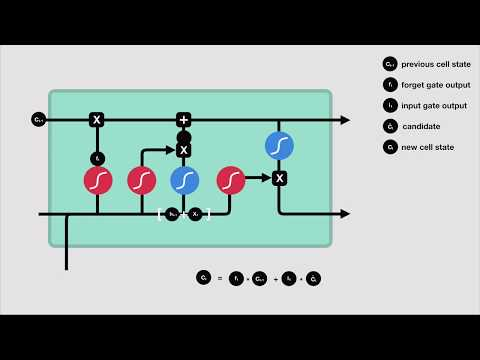

In [22]:
YouTubeVideo("8HyCNIVRbSU", width=500, height=200)

## 5.2 Why RNN might not be the best idea:
**Issues in Vanilla RNNs**: 🍦
* have short term memory, caused by the vanishing gradient problem
* as the RNN process has more steps (timestamps), it has more and more difficulty retaining information from previous steps

## 5.3 Vanishing Gradient Problem 🌪
**What is vanishing gradient**:
* it is due to the nature of backpropagation (during the optimization process)
* the steps are:
    1. a forward step through the network
    2. computing the predictions
    3. comparing the predictions with the actual values and computing a LOSS function
    4. backpropagation uses the loss to adjust the weights in the network going BACKWARDS
    5. backpropagation calculates the gradients of the nodes in each layer
* if the GRADIENT is big, the adjustment in weight is big and vice versa
* **PROBLEM**: during backpropagation, each node calculates its gradient with the respect of the effects of the gradients in the layer before it. So if the adjustment in the previous layer is small, then the adjustment in the current layer will be smaller
* **CONSEQUENCE**: the first layers of the network don't learn (because the adjustemnt are extremely small)

<img src='https://i.imgur.com/6DtSeNT.png' width=400>

## 5.4 How does LSTM work?
An LSTM is more complex than an simple RNN:
* it is composed by cell states and gates
* it has the purpose to LEARN what to remember and forget reduntant information
* it uses SIGMOID functions instead of TANH
* Composition of the cell in LSTM:
    * the cell has 2 outputs: the cell state and the hidden state
    
    1. Forget Gate (`Xt + ht-1`): desides what information to FORGET; the closer to 0 is forget, the closer to 1 is remain
    2. Input Gate (`Xt + ht-1`): creates a candidate with what information to remain
    3. Current Cell State: `ft*Ct-1 + it*Ct`
    4. Output Gate (`(Xt + ht-1) * ct`): desides what the next hidden state should be (which contains info about previous inputs)
    
> Note: [Check THIS blog post for more detailed explanation.](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
    
<img src='https://i.imgur.com/6aayOcS.png' width=300>
    
> The **Stacked LSTM** is like the Multilayer RNN: it has multiple hidden LSTM layers which contain multiple memory cells

## 5.5 LSTM for MNIST Classification 🔢

> **Bidirectional LSTMs** : are an extension of traditional LSTMs that can improve model performance on sequence classification problems. They train the model *forward* and *backward* on the same input (so for 1 layer LSTM we get 2 hidden and cell states)

<img src='https://i.imgur.com/z6iDAQB.png' width=400>

In [23]:
class LSTM_MNIST(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size, bidirectional=True):
        super(LSTM_MNIST, self).__init__()
        
        self.input_size, self.hidden_size, self.layer_size, self.output_size = input_size, hidden_size, layer_size, output_size
        self.bidirectional = bidirectional
        
        # Step1: the LSTM model
        self.lstm = nn.LSTM(input_size, hidden_size, layer_size, batch_first=True, bidirectional=bidirectional)
        
        # Step2: the FNN
        if bidirectional: # we'll have 2 more layers
            self.layer = nn.Linear(hidden_size*2, output_size)
        else:
            self.layer = nn.Linear(hidden_size, output_size)
            
            
    def forward(self, images, prints=False):
        if prints: print('images shape:', images.shape)
        
        # Set initial states
        if self.bidirectional:
            # Hidden state:
            hidden_state = torch.zeros(self.layer_size*2, images.size(0), self.hidden_size)
            # Cell state:
            cell_state = torch.zeros(self.layer_size*2, images.size(0), self.hidden_size)
        else:
            # Hidden state:
            hidden_state = torch.zeros(self.layer_size, images.size(0), self.hidden_size)
            # Cell state:
            cell_state = torch.zeros(self.layer_size, images.size(0), self.hidden_size)
        if prints: print('hidden_state t0 shape:', hidden_state.shape, '\n' +
                         'cell_state t0 shape:', cell_state.shape)
        
        # LSTM:
        output, (last_hidden_state, last_cell_state) = self.lstm(images, (hidden_state, cell_state))
        if prints: print('LSTM: output shape:', output.shape, '\n' +
                         'LSTM: last_hidden_state shape:', last_hidden_state.shape, '\n' +
                         'LSTM: last_cell_state shape:', last_cell_state.shape)
        # Reshape
        output = output[:, -1, :]
        if prints: print('output reshape:', output.shape)
        
        # FNN:
        output = self.layer(output)
        if prints: print('FNN: Final output shape:', output.shape)
        
        return output

### How the Model Works:
> Below is a schema of how the example code works
<img src='https://i.imgur.com/AEtXhKH.png' width=500>

In [24]:
# ====== STATICS ======
batch_size = 64
input_size = 28       # width of image
hidden_size = 128     # number of hidden neurons
layer_size = 2        # number of layers
output_size = 10      # possible choices
# =====================

In [25]:
# Taking a single batch of the images
images, labels = next(iter(train_loader_example))
print('original images shape:', images.shape)
# Remove channel from shape
images = images.reshape(-1, 28, 28)
print('reshaped images shape:', images.shape, '\n')

# Creating the Model
lstm_example = LSTM_MNIST(input_size, hidden_size, layer_size, output_size)
print('lstm_example:', lstm_example, '\n')

# Making log predictions:
out = lstm_example(images, prints=True)

original images shape: torch.Size([64, 1, 28, 28])
reshaped images shape: torch.Size([64, 28, 28]) 

lstm_example: LSTM_MNIST(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True, bidirectional=True)
  (layer): Linear(in_features=256, out_features=10, bias=True)
) 

images shape: torch.Size([64, 28, 28])
hidden_state t0 shape: torch.Size([4, 64, 128]) 
cell_state t0 shape: torch.Size([4, 64, 128])
LSTM: output shape: torch.Size([64, 28, 256]) 
LSTM: last_hidden_state shape: torch.Size([4, 64, 128]) 
LSTM: last_cell_state shape: torch.Size([4, 64, 128])
output reshape: torch.Size([64, 256])
FNN: Final output shape: torch.Size([64, 10])


### Training on ALL IMAGES 🚀

In [26]:
# ==== STATICS ====
batch_size = 64
input_size = 28
hidden_size = 100  
layer_size = 2         
output_size = 10

# Instantiate the model
# We'll use TANH as our activation function
lstm_rnn = LSTM_MNIST(input_size, hidden_size, layer_size, output_size)

# ==== TRAIN ====
train_network(lstm_rnn, mnist_train, mnist_test, num_epochs=1)

Get data ready...
Training started...
TRAIN | Epoch: 1/1 | Loss: 0.46 | Accuracy: 0.85
Testing Started...
TEST | Average Accuracy per 155 Loaders: 0.96502


> Now we get even *HIGHER* accuracies than the ones before. 
> If we make a recap, FNNs from my previous notebook had an accuracy of ~ 80%, CNNs had and accuracy of almost 90%, while RNN reached 97%. Lastly, **LSTMs** were the best performing ones (99% accuracy).

# 6. Bonuses ➕
## 6.1 Confusion Matrix 🤔

A good way to visualize better how the model is performing is through a confusion matrix. So, you can see how well each label is predicted and what labels the model confuses with other labels (for example a 7 can be sometimes confused with 1).

In [27]:
def get_confusion_matrix(model, test_data):
    # First we make sure we disable Gradient Computing
    torch.no_grad()
    
    # Model in Evaluation Mode
    model.eval()
    
    preds, actuals = [], []

    for image, label in mnist_test:
        image = image.view(-1, 28, 28)
        out = model(image)

        prediction = torch.max(out, dim=1)[1].item()
        preds.append(prediction)
        actuals.append(label)
    
    return sklearn.metrics.confusion_matrix(preds, actuals)

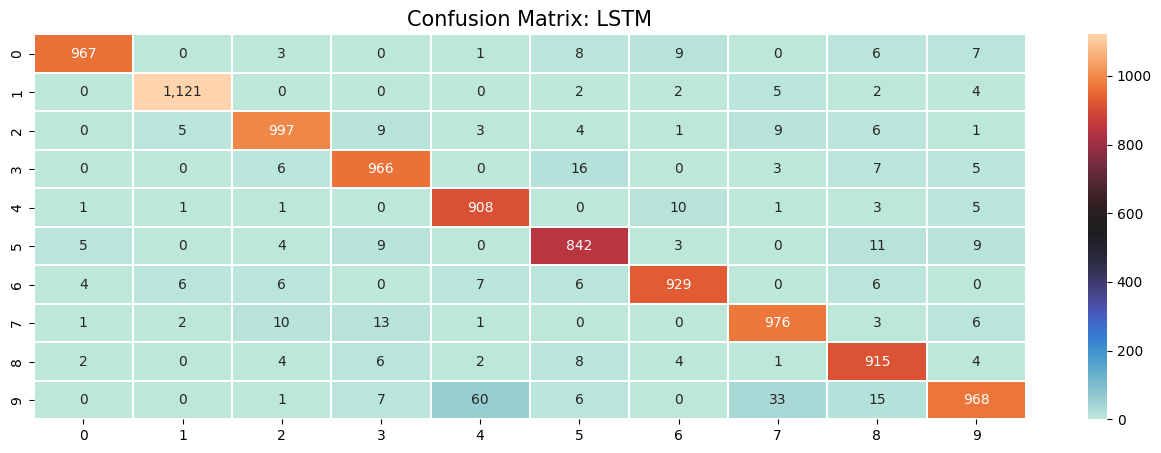

In [28]:
plt.figure(figsize=(16, 5))
sns.heatmap(get_confusion_matrix(lstm_rnn, mnist_test), cmap='icefire', annot=True, linewidths=0.1,
           fmt = ',')
plt.title('Confusion Matrix: LSTM', fontsize=15);

## 6.2 Why shouldn't you use Transfer Learning?🧠

Transfer learning is a genious way to use the weights of a pretrained model on another set of images. This technique is often used in deep learning classification problems that use CNN (like EffNets, ResNets etc).

However, this is not a regular technique used for RNN networks. This is mainly because *recurrent* data cannot really be generalized like static data (images) can be.

[Read more about this here.](https://www.quora.com/In-recurrent-neural-networks-like-LSTMs-is-it-possible-to-do-transfer-learning-Has-there-been-any-research-in-this-area)

# Other How I taught myself Deep Learning Notebooks📋
* [How I taught myself Deep Learning: Vanilla NNs](https://www.kaggle.com/andradaolteanu/how-i-taught-myself-deep-learning-1-pytorch-fnn)
* [Convolutional Neural Nets (CNNs) Explained](https://www.kaggle.com/andradaolteanu/convolutional-neural-nets-cnns-explained)

If you have any questions, please do not hesitate to ask. This notebook is made to bring more clear understanding of concepts and coding, so this would also help me add, modify and improve it. 

<div class="alert alert-block alert-warning"> 
<p>If you liked this, upvote!</p>
<p>Cheers!</p>
</div>

# References📇:
* [Illustrated Guide to Recurrent Neural Networks: Understanding the Intuition](https://www.youtube.com/watch?v=LHXXI4-IEns)
* [Illustrated Guide to LSTM's and GRU's: A step by step explanation](https://www.youtube.com/watch?v=8HyCNIVRbSU)
    * [Also the blog post](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
* [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)